In [2]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import *
from utils.manifold_utils import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import *
import os
from tqdm import tqdm
from typing import Dict, Any

In [3]:
torch.manual_seed(3420934659826)

In [4]:
run_parameters =  yaml.safe_load(Path("./configs/sphere_euclidean.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 100001,
  'batch_size': 100,
  'inf_every': 4000,
  'print_every': 4000,
  'device': 'cpu',
  'inf_runs_num': 1,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 3,
  'manifold': 'Sphere',
  'datasets': ['Sine'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 2.0,
  'downsample': 5,
  'sample_points': 300,
  'mean': 0.0,
  'std': 0.5},
 'ema': {'warmup': 2000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 10000, 'gamma': 0.5}}

In [5]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
train_sets= list(range(6)) #+ list(range(7, 13)) + list(range(14, 20)) + list(range(21, 27))
val_sets = [6]#, 13, 20, 27]
print(train_sets, val_sets)

[0, 1, 2, 3, 4, 5] [6]


In [6]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'])

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_obs.shape)

7
1
6
torch.Size([1, 200, 7])


In [7]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e
    
def get_parameters_from_run(run_name):
    return yaml.safe_load(Path(os.path.join('./runs', run_name, 'config.yaml')).read_text())

def get_model(run_name, action_dim=None):
    parameters = get_parameters_from_run(run_name)
    act_dim = action_dim if action_dim is not None else parameters['data']['dim']
    vf = StateMLP(
        action_dim=act_dim,
        hidden_dim=parameters['model']['hidden_dim'],
        horizon_size=parameters['data']['horizon_size'],
        num_layers=parameters['model']['num_layers'],
        label_embedding_dim=parameters['model']['embed_dim'],
        num_classes=len(parameters['data']['datasets'])
    )
    vf.load_state_dict(torch.load(os.path.join("./runs", run_name, "best_model.pth"), weights_only=True))
    return vf

In [8]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(LASA_datasets)
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 84304


In [9]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=True)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=Euclidean())

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            train_loss = step_euc_sphere(vf=vf, 
                                        batch=batch, 
                                        run_parameters=run_parameters, 
                                        path=path, 
                                        device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                plt.figure()
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(save_path,'loss_plot.png'))
                plt.close()

                plt.figure()
                plt.plot(lrs, label='Learning rate')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('lr')
                plt.legend()
                plt.savefig(os.path.join(save_path,'lr_plot.png'))
                plt.close()
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step_euc_sphere(vf=vf, 
                                                batch=val_batch, 
                                                run_parameters=run_parameters, 
                                                path=path, 
                                                device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    if loss_val.item() < best_val_loss:
                        best_val_loss = loss_val.item()
                        torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=Euclidean(),
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs,
                                inference_type="Euclidean sphere")
                    for label_name in infered.keys():
                        print(len(infered[label_name]['results']))
                        plot_3d_points_interactive(infered[label_name]['results'])
                    ema_vf.restore()
                start_time = time.time()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

In [10]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold, 
            ema_vf=ema_vf, dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="sine_ambient_S2")

| iter      0 |  0.09 sec | train loss    0.571 
| iter      0 | validation loss:    0.597 


1


Output()

| iter   4000 | 37.93 sec | train loss    0.023 
| iter   4000 | validation loss:    0.020 


1


Output()

| iter   8000 | 38.83 sec | train loss    0.012 
| iter   8000 | validation loss:    0.011 


1


Output()

| iter  12000 | 42.32 sec | train loss    0.010 
| iter  12000 | validation loss:    0.007 


1


Output()

| iter  16000 | 44.00 sec | train loss    0.009 
| iter  16000 | validation loss:    0.008 


1


Output()

| iter  20000 | 43.56 sec | train loss    0.006 
| iter  20000 | validation loss:    0.006 


1


Output()

| iter  24000 | 44.30 sec | train loss    0.005 
| iter  24000 | validation loss:    0.006 


1


Output()

| iter  28000 | 36.80 sec | train loss    0.004 
| iter  28000 | validation loss:    0.005 


1


Output()

| iter  32000 | 36.51 sec | train loss    0.005 
| iter  32000 | validation loss:    0.005 


1


Output()

| iter  36000 | 37.21 sec | train loss    0.004 
| iter  36000 | validation loss:    0.003 


1


Output()

| iter  40000 | 42.20 sec | train loss    0.003 
| iter  40000 | validation loss:    0.003 


1


Output()

| iter  44000 | 43.60 sec | train loss    0.003 
| iter  44000 | validation loss:    0.003 


1


Output()

| iter  48000 | 41.63 sec | train loss    0.005 
| iter  48000 | validation loss:    0.004 


1


Output()

| iter  52000 | 43.68 sec | train loss    0.004 
| iter  52000 | validation loss:    0.005 


1


Output()

| iter  56000 | 44.97 sec | train loss    0.004 
| iter  56000 | validation loss:    0.003 


1


Output()

| iter  60000 | 43.35 sec | train loss    0.005 
| iter  60000 | validation loss:    0.006 


1


Output()

| iter  64000 | 39.26 sec | train loss    0.004 
| iter  64000 | validation loss:    0.005 


1


Output()

| iter  68000 | 39.43 sec | train loss    0.004 
| iter  68000 | validation loss:    0.003 


1


Output()

| iter  72000 | 44.28 sec | train loss    0.003 
| iter  72000 | validation loss:    0.003 


1


Output()

| iter  76000 | 45.82 sec | train loss    0.005 
| iter  76000 | validation loss:    0.003 


1


Output()

| iter  80000 | 46.27 sec | train loss    0.004 
| iter  80000 | validation loss:    0.004 


1


Output()

| iter  84000 | 45.10 sec | train loss    0.003 
| iter  84000 | validation loss:    0.004 


1


Output()

| iter  88000 | 39.13 sec | train loss    0.004 
| iter  88000 | validation loss:    0.002 


1


Output()

| iter  92000 | 34.25 sec | train loss    0.003 
| iter  92000 | validation loss:    0.003 


1


Output()

| iter  96000 | 41.98 sec | train loss    0.004 
| iter  96000 | validation loss:    0.004 


1


Output()

| iter 100000 | 41.55 sec | train loss    0.005 
| iter 100000 | validation loss:    0.006 


1


Output()

In [11]:
vf = get_model("sine_ambient_S2")

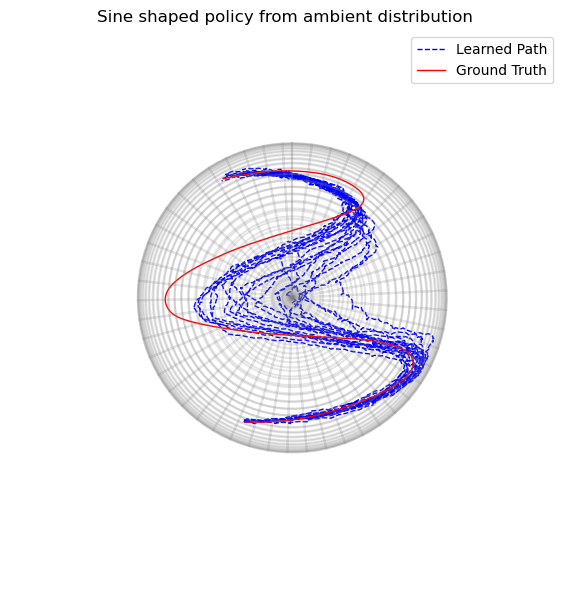

In [18]:
class_labels = dataset.get_label_maping()
dtw = []
for label_name in list(class_labels.keys()):
    results = []
    samples = []
    errors = []
    for _ in range(20): 
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        res, samp, paths = infer_model(
                                model=vf, 
                                start=gt_obs[class_labels[label_name],0,:run_parameters['data']['dim']], 
                                manifold=manifold,
                                label=label,
                                dim_manifold=run_parameters['data']['dim'],
                                model_horizon=run_parameters['data']['horizon_size'],
                                inference_horizon=run_parameters['data']['inference_horizon'],
                                sample_points=240,
                                mean=run_parameters['data']['mean'],
                                std=run_parameters['data']['std'],
                                project_infered=True,
                                step_size=0.05
                            )
        results.append(res)
        samples.append(samp)

        # dtw.append(dtw_distance(A=res, B=gt_obs[0,:,:3], dist_func=spherical_distance))
    plot_flow_on_sphere(results, 
                        samples_list=samples, 
                        gt_samples=gt_obs[class_labels[label_name]], 
                        label=label_name, 
                        dynamic=False, one_canvas=True, plot_samples=False, line_type='--', axis_off=True, title="Sine shaped policy from ambient distribution")

In [16]:
dtw = []
for i in range(len(results)):
    dtw.append(dtw_distance(results[i], gt_obs[0,:,:3], dist_func=spherical_distance))

In [17]:
dtw = np.array(dtw)
print(dtw.mean(), dtw.std())

43.259506 17.859404
